# ML project

### imports and aux functions

In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from dataretrieval import nwis, utils, codes

import json
from urllib.request import urlopen

from wlearning import utils as ut #my project module

#sns.set_style("whitegrid")
sns.set_style("darkgrid")


### Getting the list of stations along the Mississippi river

We want all the stations along the mainstream Mississippi river. We use the swager API to tranverse upstream and select all the water surface stations

In [54]:
FEATURE = "nwissite"
FEATURE_ID = "USGS-07374525" # usgs station
NAVIGATION_MODE = "UM"
UPSTREAM_DISTANCE = "9999" # in km

url = (
    "https://labs.waterdata.usgs.gov/api/nldi/linked-data/"
    + FEATURE + "/"
    + FEATURE_ID+"/"
    + "navigation/"
    + NAVIGATION_MODE+"/"
    + "nwissite?"
    + "distance="+UPSTREAM_DISTANCE
)

print(url)
response = urlopen(url)
data_json = json.loads(response.read())

https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-07374525/navigation/UM/nwissite?distance=9999


and then filter them by those that have recent discharge data

In [55]:
param_cd =["00060"] 
param_name = ["mean discharge CFS"]

start="2016-01-01"
end="2016-12-31"

site_list = []
for feature in data_json["features"]:
    site = str.removeprefix(feature["properties"]["identifier"],"USGS-")
    site_df, meta = nwis.get_dv(sites=site, start=start, end=end, parameterCd=param_cd)
    if not site_df.empty:
        site_list.append(site)

site_list


['05331580',
 '07289000',
 '07032000',
 '07374525',
 '05207600',
 '07020500',
 '05242300',
 '05587450',
 '05270700',
 '07374000',
 '05200510',
 '05355341',
 '05420500',
 '05267000',
 '07022000',
 '05344500',
 '05227500',
 '05378500',
 '05474500',
 '05288500',
 '05355250',
 '05211000',
 '05331000',
 '07010000']

Finally, we sort them by latitude to match the upstream direction

In [84]:
latitudes = []
for site_ID in site_list:
    url = (
        "https://labs.waterdata.usgs.gov/api/nldi/linked-data/"
        + FEATURE + "/"
        + "USGS-"+site_ID
    )
    response = urlopen(url)
    data_json = json.loads(response.read())
    _, latitude = data_json["features"][0]["geometry"]["coordinates"]
    latitudes.append(latitude)

df_sites = pd.DataFrame()
df_sites["sites"] = site_list
df_sites["latitude"] = latitudes
df_sites.sort_values(by=["latitude"], inplace=True)
df_sites.to_csv("Mississippi_sites.csv", index=False)
df_sites

,sites,latitude
3,07374525,29.857151
9,07374000,30.445667
1,07289000,32.315000
2,07032000,35.123146
14,07022000,37.221600
5,07020500,37.900742
23,07010000,38.629000
7,05587450,38.967972
18,05474500,40.393655
12,05420500,41.780586


### Download data

In [2]:
# reading site list
df_sites = pd.read_csv("Mississippi_sites.csv", dtype="string")
df_sites.drop(columns="latitude", inplace=True)

In [9]:
# making a list of corresponding upstream and downstream sites
n = len(df_sites["sites"])
upstream = df_sites["sites"][1:].values
downstream = df_sites["sites"][:-1].values
# save this pairs for later
station_pairs = pd.DataFrame()
station_pairs["upstream"] = upstream 
station_pairs["downstream"] = downstream
station_pairs.to_csv("./results/stations_pairs.csv",index=False)

In [10]:
# downloading data for a date range from the up to down sites
date_format="YYYY-MM-DDTHH:SS:MM"
param_cd =["00060"] 
param_name = ["mean discharge CFS"]
start="1950-01-01"
end="2019-12-31"

for up_site, down_site in zip(upstream, downstream):
    # Download, remove extra columns and rename
    up_df, _meta = nwis.get_dv(
        sites=up_site, start=start, end=end, parameterCd=param_cd)
    up_df.drop(columns=["00060_Mean_cd","site_no"], inplace=True)
    up_df.rename(columns={"00060_Mean" : "upstream" }, inplace=True)

    down_df, _meta = nwis.get_dv(
        sites=down_site, start=start, end=end, parameterCd=param_cd)
    down_df.drop(columns=["00060_Mean_cd","site_no"],inplace=True)
    down_df.rename(columns={"00060_Mean" : "downstream" }, inplace=True)
    # Join them in a single df
    joint = pd.merge(up_df,down_df,how="inner",left_index=True, right_index=True)
    joint.to_csv("./data/joint_" + down_site + ".csv")



### Methodology

1. Pick a time range to test
2. Split dates into: 60% earliest dates for train, 20% nextdates for validation, and the last 20% for testing.
3. Do a linear regression analysis for exploration
4. For SVM tunning
    1. do I need standarizing data? (pipeline)
    2. parameter space tunning and kernel pick

In [1]:
start="2015-01-01"
train="2018-01-01"
validation="2019-01-01"
test="2020-01-01"

In [2]:
# get filenames from station_pairs and read station_pairs with lags and corrs
F_PREFIX = "joint_"
station_pairs=pd.read_csv(
    "./results/stations_pairs.csv", 
    dtype={"upstream":"string","downstream":"string","lag":"int","corr":"float"}
    )
stations = station_pairs["downstream"].values
filenames = [F_PREFIX + station +".csv" for station in stations]
lags = station_pairs["lag"].values

### Find the lags

In [ ]:
# Find the max cross correlations and lags
lags = []
corrs = []
for file in filenames:
    data = pd.read_csv("./data/"+file, index_col="datetime")
    data.index =pd.to_datetime(data.index)    
    lag=-10; corr=-1
    for year in range(2015,2018):
        firstday = pd.Timestamp(str(year)+"-01-01",tz=data.index[0].tz)
        lastday = pd.Timestamp(str(year)+"-12-31",tz=data.index[0].tz)
        one_year_data = data[firstday:lastday]
        # find the max lag at that year
        if one_year_data.size>150:
            max_lag, _corrs = ut.cross_corr(
            df1 = one_year_data,
            tag1="upstream", tag2="downstream", 
            shift_range=(-10,10))
            if max(_corrs)>=corr:
                corr = max(_corrs)
                lag = max(lag, max_lag)
    lags.append(lag)
    corrs.append(corr)

In [ ]:
# save lag information on station_pairs
station_pairs["lag"]=lags
station_pairs["corr"]=corrs
station_pairs.to_csv("./results/stations_pairs.csv",index=False)

### Linear regression


c:\Users\Paquito\anaconda3\envs\ML\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


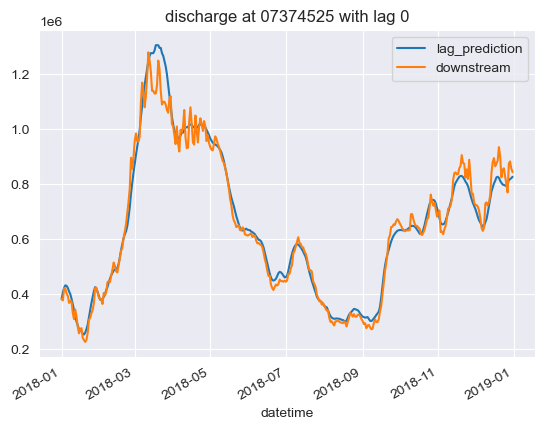

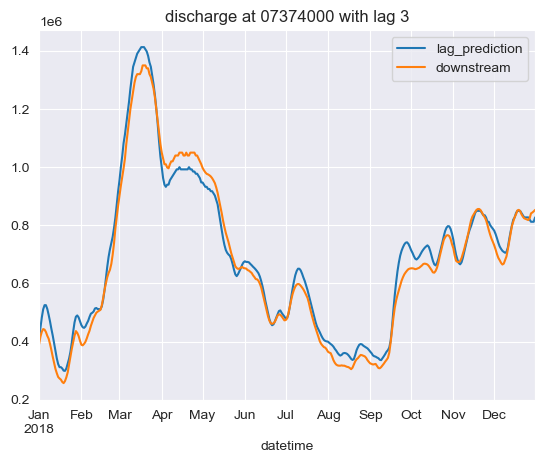

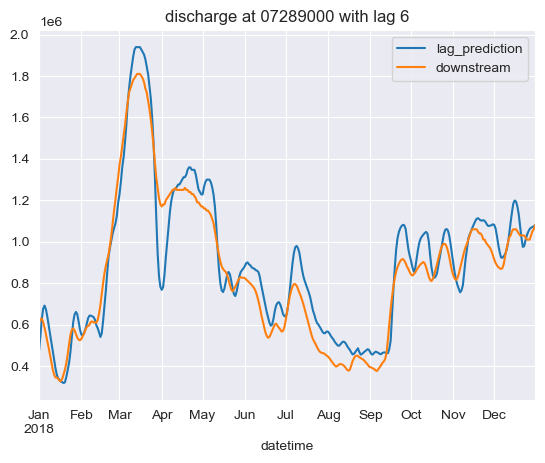

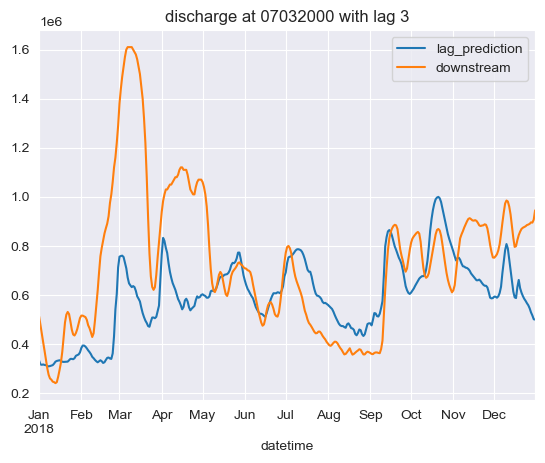

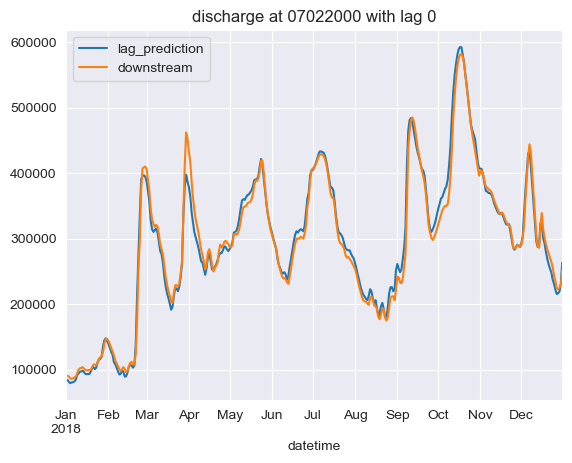

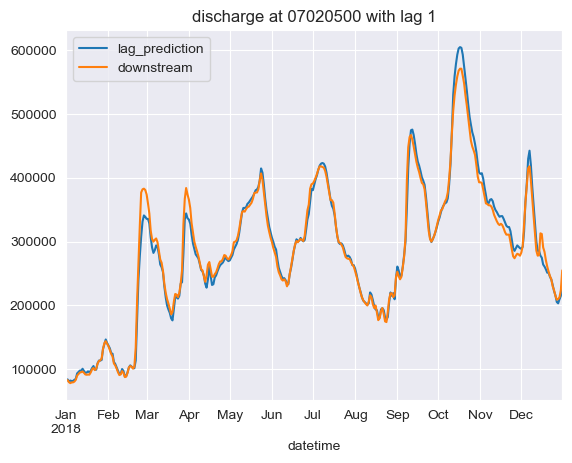

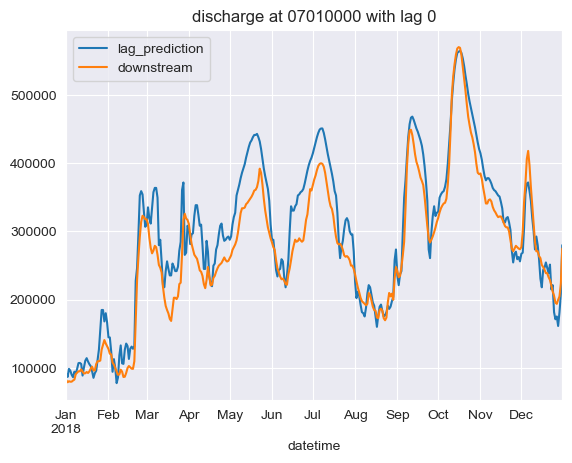

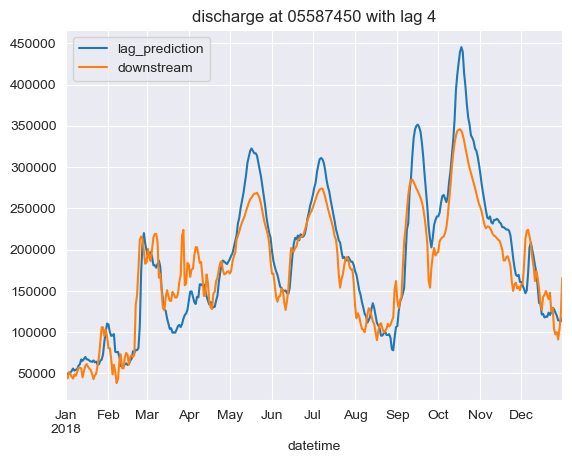

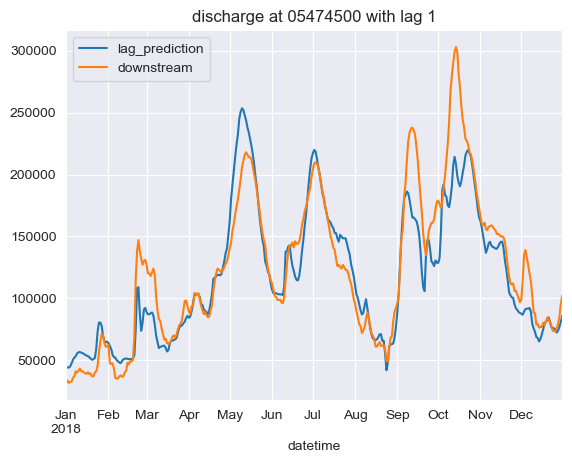

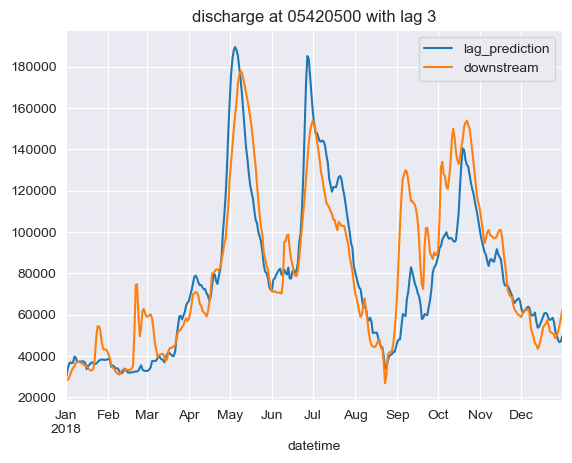

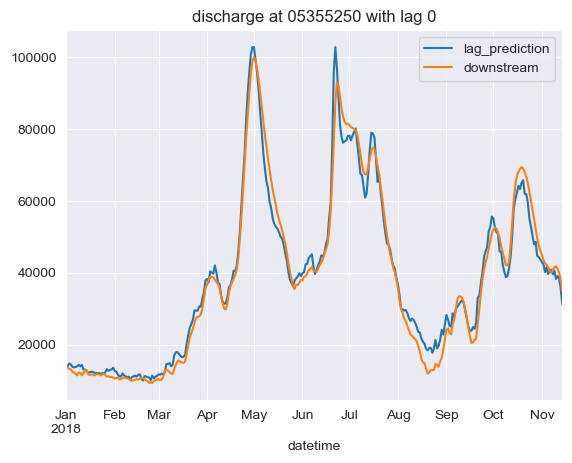

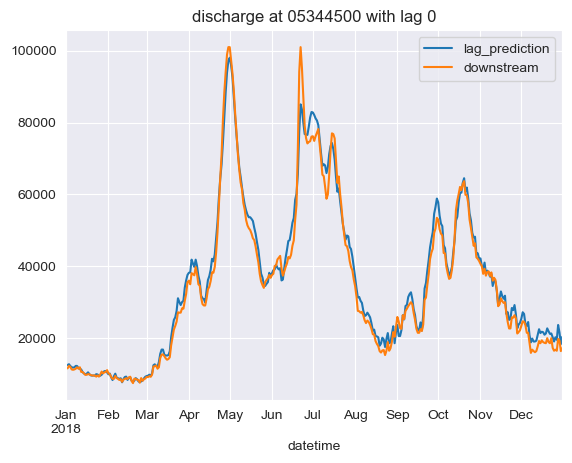

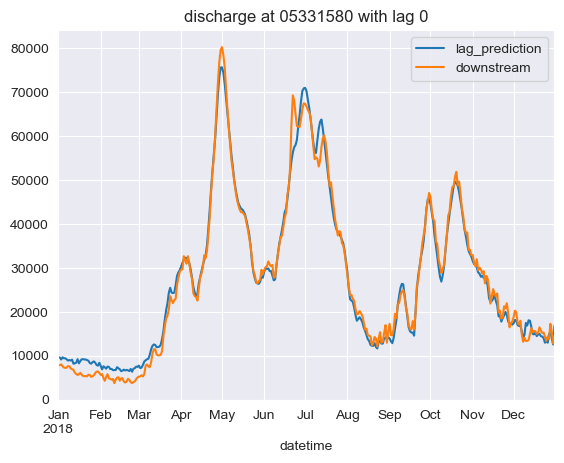

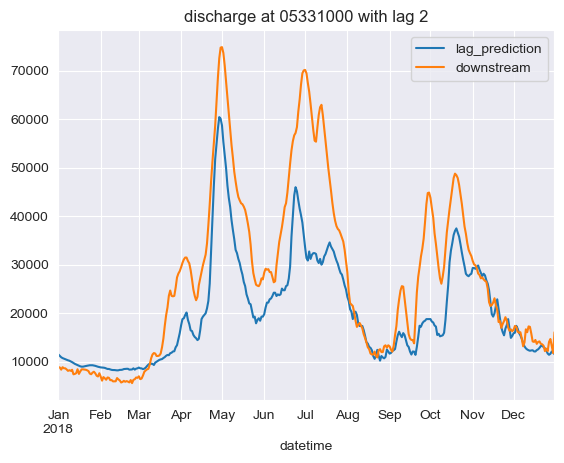

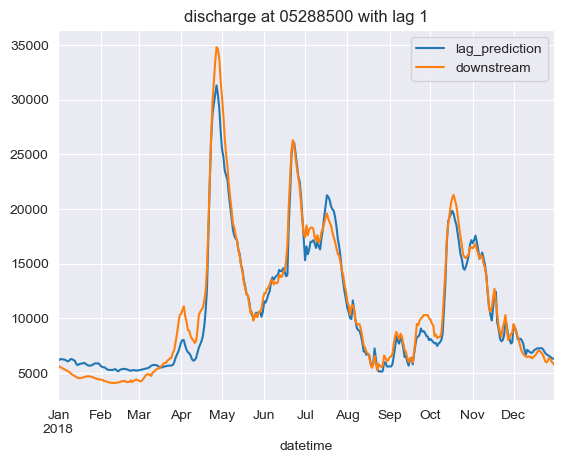

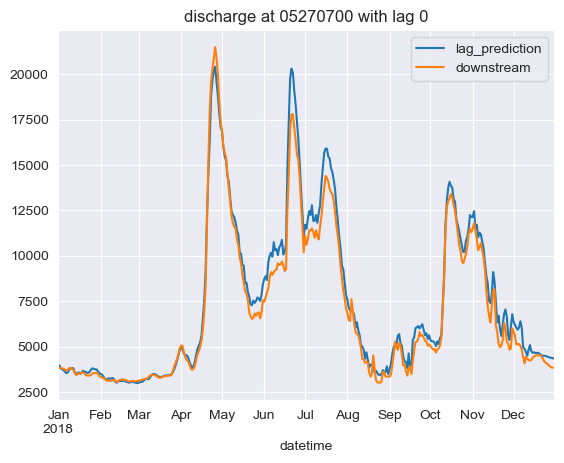

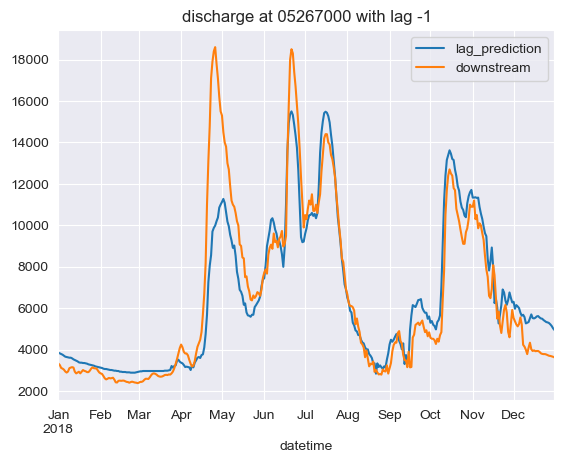

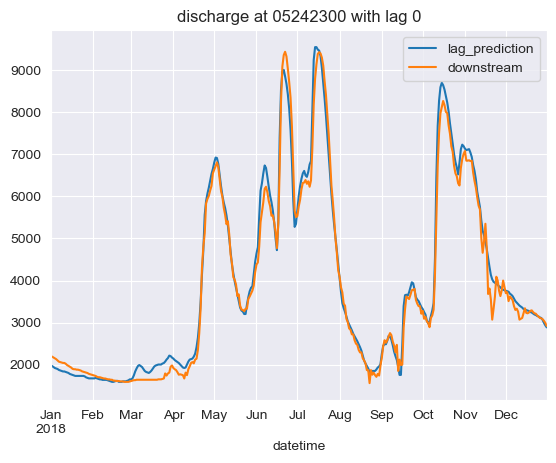

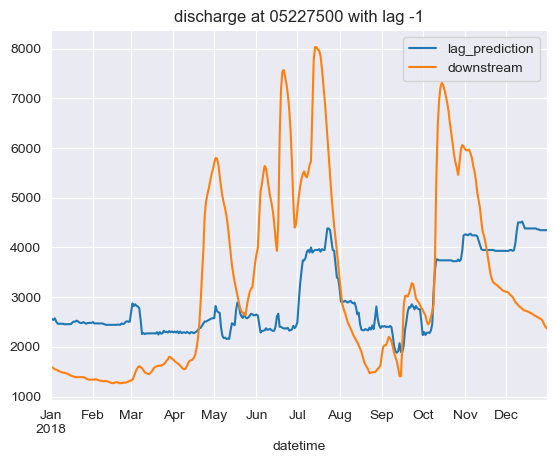

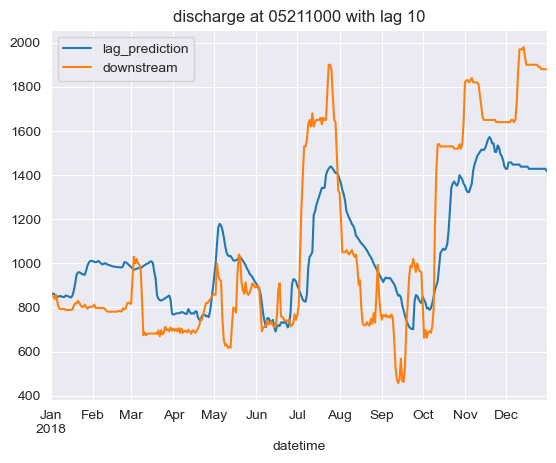

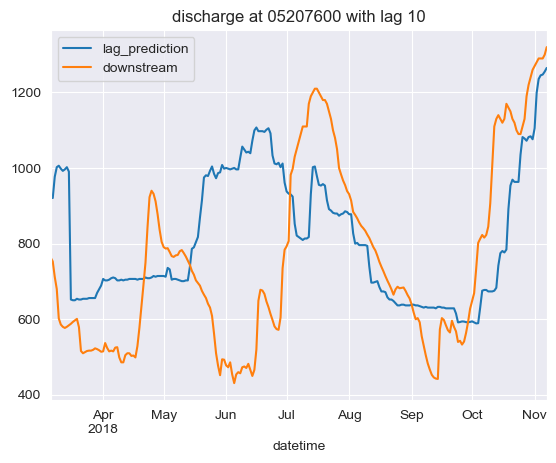

In [18]:
# Train linear regression
N = len(filenames)
train_errors = []
valid_errors = []
extra_errors = []
test_errors = []
avg_rel_errors = []
# remember to read stations pairs beforehand
for i in range(N):
    # get data at one reach
    file = filenames[i] 
    data = pd.read_csv("./data/"+file, index_col="datetime")
    data.index =pd.to_datetime(data.index)

    # new columns of lag data
    data["lag_upstream"] = data["upstream"].shift(lags[i])

    # get training data (3 years)
    firstday = pd.Timestamp("2015-01-01",tz=data.index[0].tz)
    lastday = pd.Timestamp("2017-12-31",tz=data.index[0].tz)
    train_df = data[firstday:lastday].copy()
    train_df.dropna(inplace=True)

    # Regression
    reg_lag = LinearRegression() 
    if train_df.size>50:
        X = train_df[["lag_upstream"]].values
        y = train_df["downstream"].values
        reg_lag.fit(X,y)
        
        # train errors
        y_train_lag = reg_lag.predict(X)
        train_errors.append( (mean_squared_error(y,y_train_lag))**0.5 )
    else:
        train_errors.append( None )

    # validation errors
    firstday = pd.Timestamp("2018-01-01",tz=data.index[0].tz)
    lastday = pd.Timestamp("2018-12-31",tz=data.index[0].tz)
    valid_df = data[firstday:lastday].copy()
    valid_df.dropna(inplace=True)

    if valid_df.size>50:
        X = valid_df[["lag_upstream"]].values
        y = valid_df["downstream"].values

        y_valid_lag = reg_lag.predict(X)
        valid_df["lag_prediction"] = y_valid_lag
        valid_df.plot(
            y=["lag_prediction","downstream"],
            use_index=True,
            title="discharge at "+stations[i]+" with lag "+str(lags[i])
            )
        plt.legend()

        valid_df["rel_err"] = (valid_df["lag_prediction"]-valid_df["downstream"])/valid_df["downstream"]
        avg_rel_errors.append( valid_df["rel_err"].mean() )
        valid_errors.append( (mean_squared_error(y,y_valid_lag))**0.5 )
    else:
        valid_errors.append( None )
        avg_rel_errors.append( None)


<AxesSubplot:xlabel='downstream'>

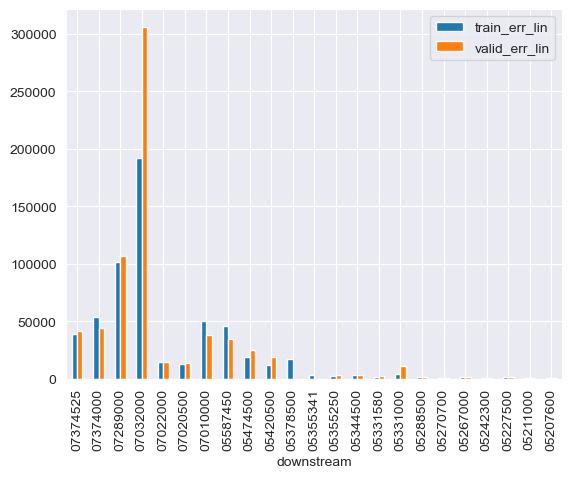

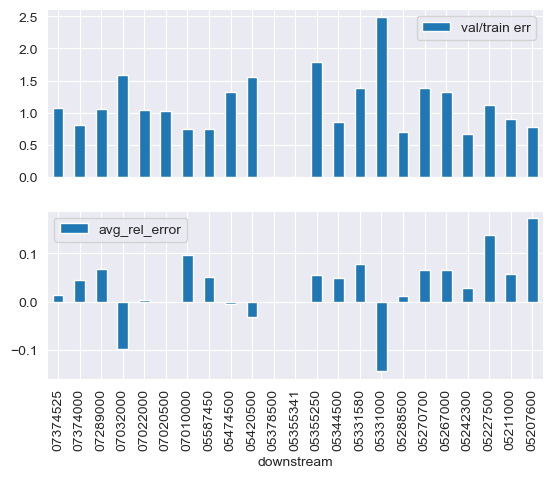

In [37]:
# calculate and plot relative erros
station_pairs["train_err_lin"] = train_errors
station_pairs["valid_err_lin"] = valid_errors
station_pairs["val/train err"] = station_pairs["valid_err_lin"]/station_pairs["train_err_lin"]
station_pairs["avg_rel_error"] = avg_rel_errors

station_pairs

station_pairs.plot(kind="bar", x="downstream", y=["train_err_lin","valid_err_lin"])
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
station_pairs.plot(kind="bar", x="downstream", y="val/train err", ax=axes[0])
station_pairs.plot(kind="bar", x="downstream", y="avg_rel_error",ax=axes[1])


c:\Users\Paquito\anaconda3\envs\ML\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


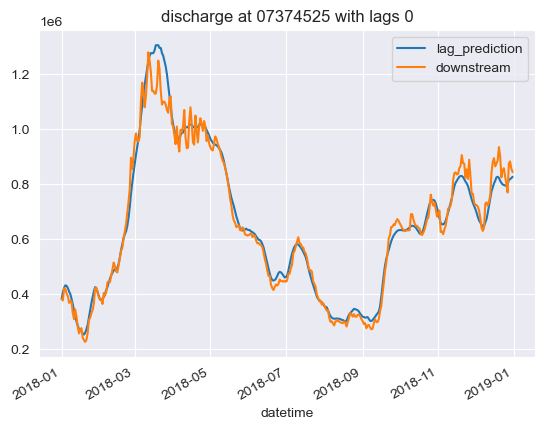

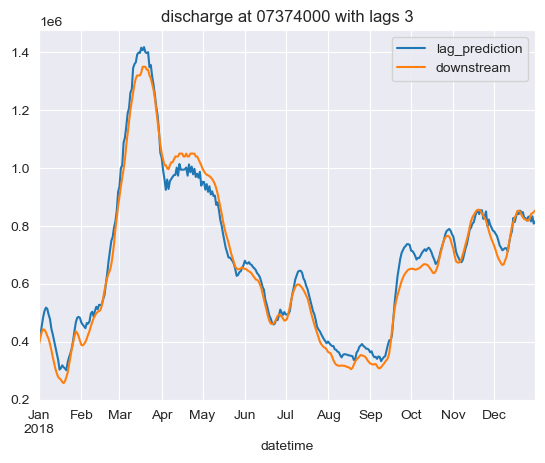

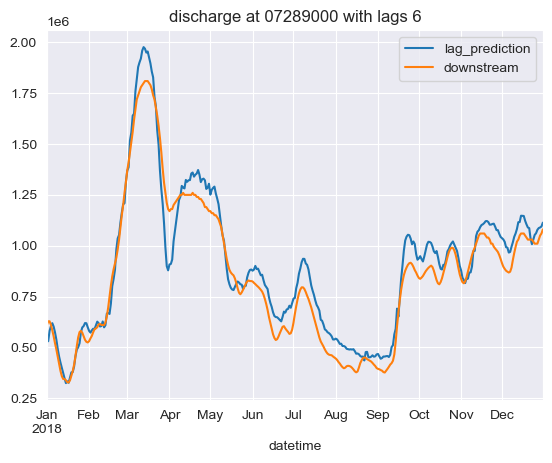

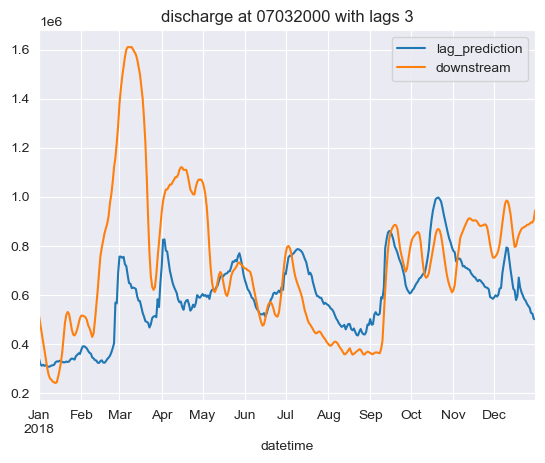

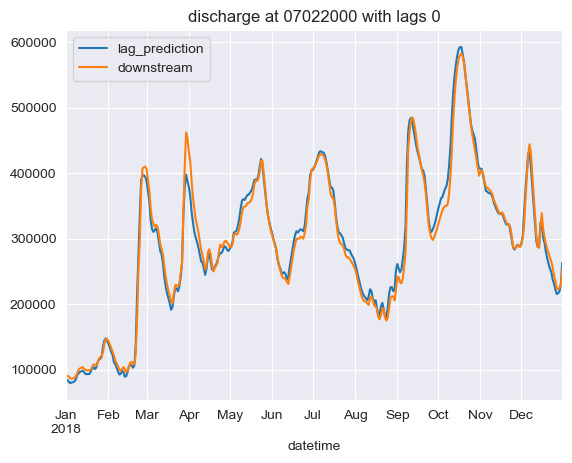

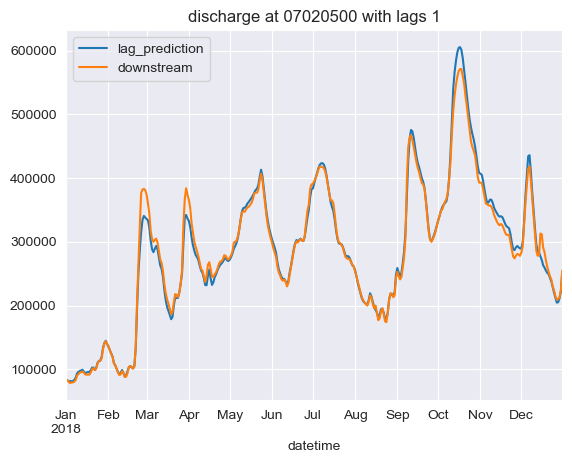

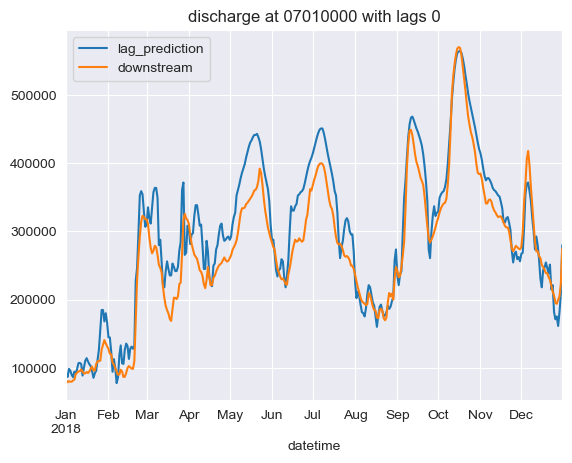

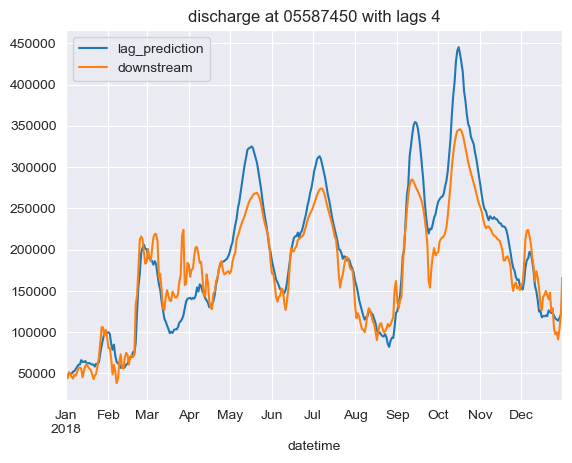

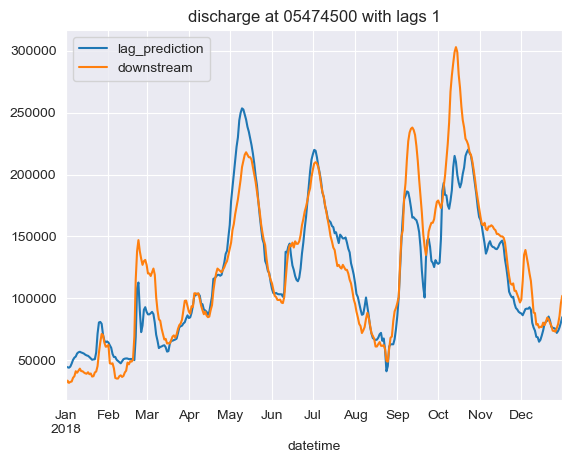

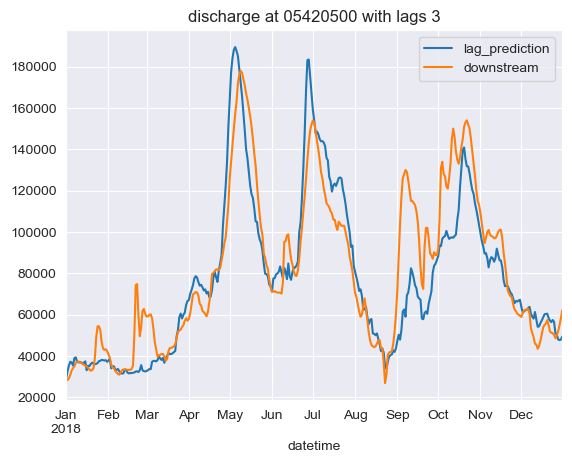

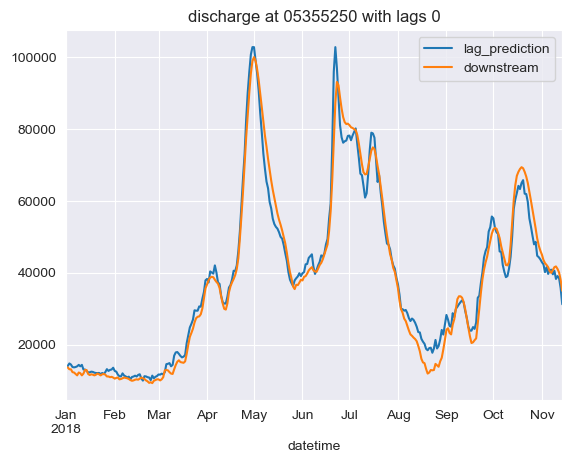

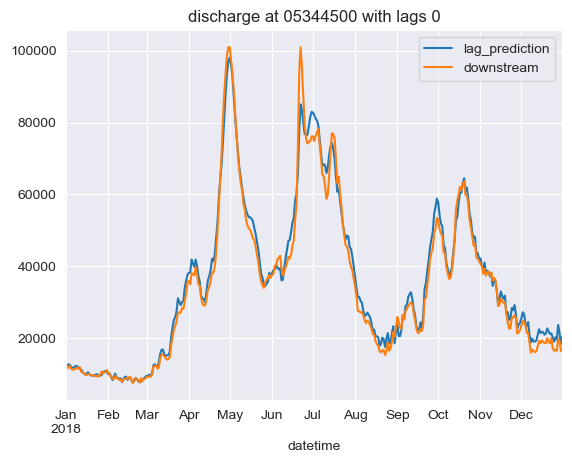

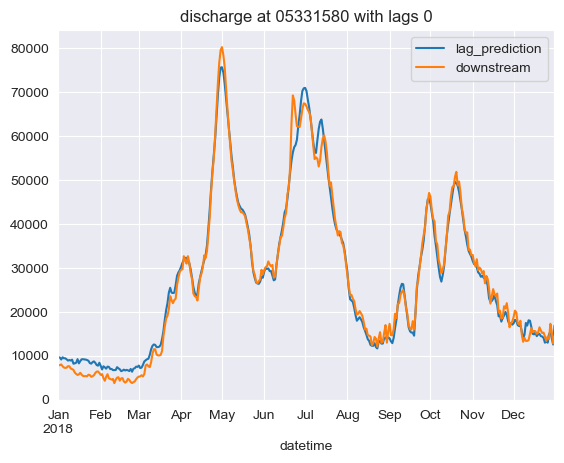

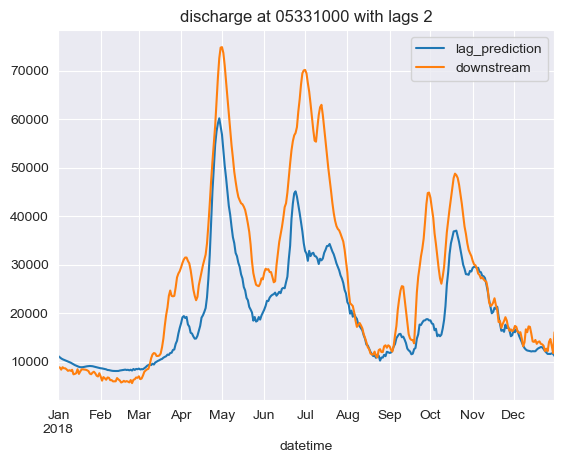

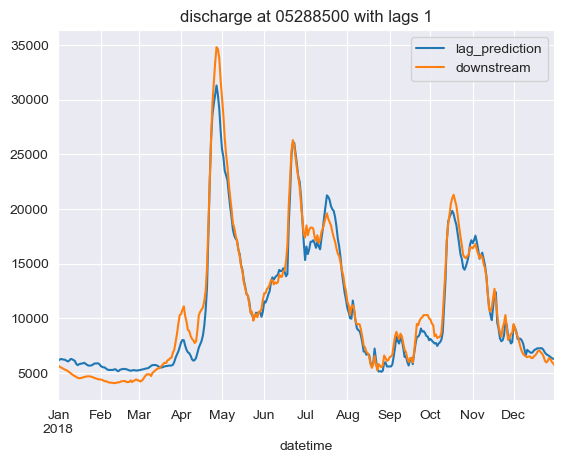

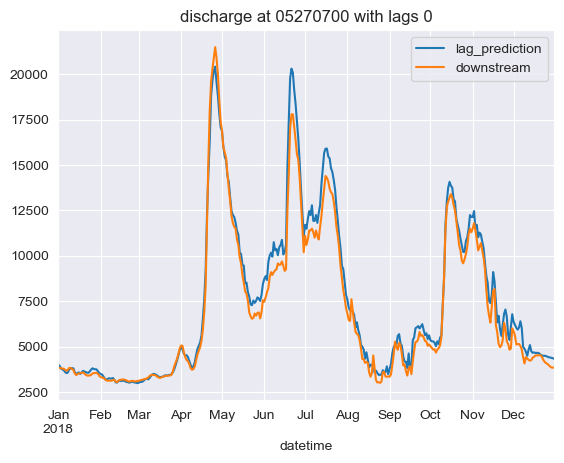

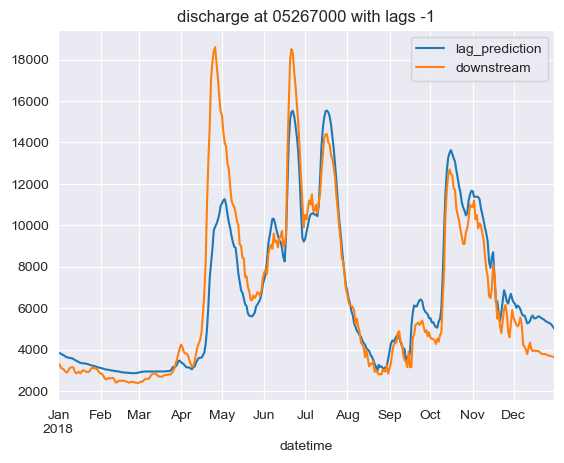

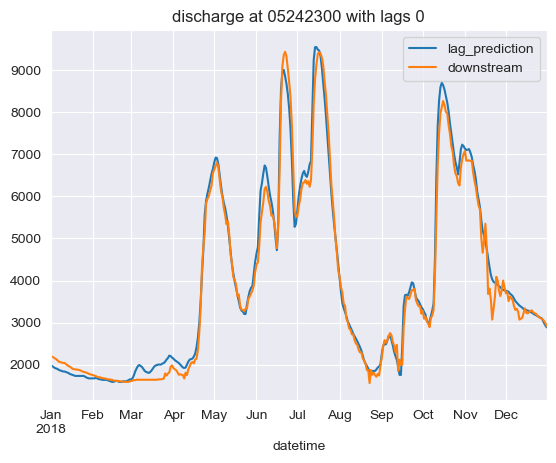

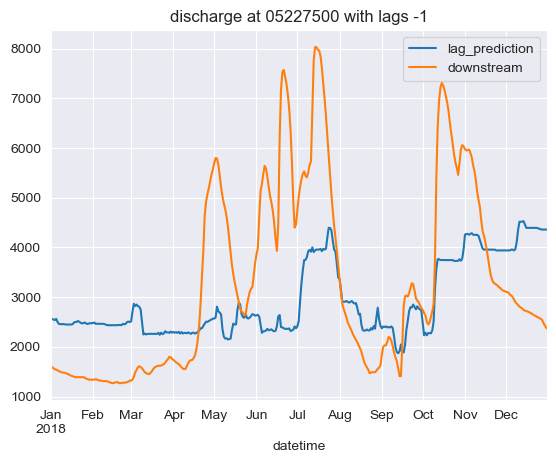

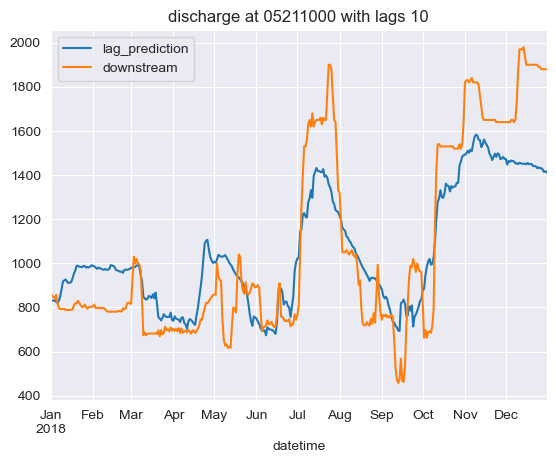

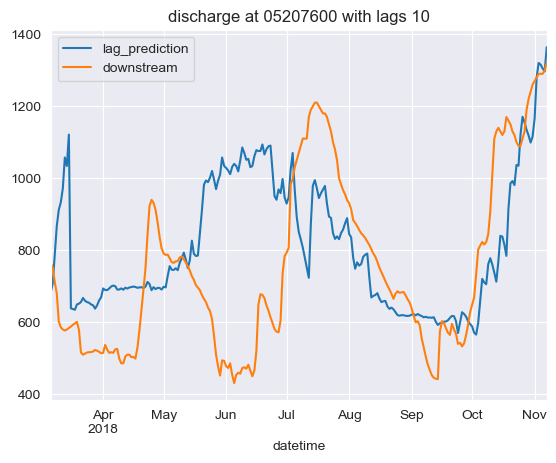

In [ ]:
# Train multiple lags Linear regression
N = len(filenames)
train_errors = []
valid_errors = []
extra_errors = []
test_errors = []
avg_rel_errors = []
# remember to read stations pairs beforehand
for i in range(N):
    # get data at one reach
    file = filenames[i] 
    data = pd.read_csv("./data/"+file, index_col="datetime")
    data.index =pd.to_datetime(data.index)

    # new columns of lag data
    lag_keys = []
    step = 1 if lags[i]>=0 else -1
    current_lag = 0
    for _ in range(abs(lags[i])+1):
        key = "lag_"+str(current_lag)
        lag_keys.append(key)
        data[key] = data["upstream"].shift(current_lag)
        current_lag = current_lag+step

    # get training data (3 years)
    firstday = pd.Timestamp("2015-01-01",tz=data.index[0].tz)
    lastday = pd.Timestamp("2017-12-31",tz=data.index[0].tz)
    train_df = data[firstday:lastday].copy()
    train_df.dropna(inplace=True)

    # Regression
    reg_lag = LinearRegression() 
    if train_df.size>50:
        X = train_df[lag_keys].values
        y = train_df["downstream"].values
        reg_lag.fit(X,y)
        
        # train errors
        y_train_lag = reg_lag.predict(X)
        train_errors.append( (mean_squared_error(y,y_train_lag))**0.5 )
    else:
        train_errors.append( None )

    # validation errors
    firstday = pd.Timestamp("2018-01-01",tz=data.index[0].tz)
    lastday = pd.Timestamp("2018-12-31",tz=data.index[0].tz)
    valid_df = data[firstday:lastday].copy()
    valid_df.dropna(inplace=True)

    if valid_df.size>50:
        X = valid_df[lag_keys].values
        y = valid_df["downstream"].values

        y_valid_lag = reg_lag.predict(X)
        valid_df["lag_prediction"] = y_valid_lag
        valid_df.plot(
            y=["lag_prediction","downstream"],
            use_index=True,
            title="discharge at "+stations[i]+" with lags "+str(lags[i])
            )
        plt.legend()

        valid_df["rel_err"] = (valid_df["lag_prediction"]-valid_df["downstream"])/valid_df["downstream"]
        avg_rel_errors.append( valid_df["rel_err"].mean() )
        valid_errors.append( (mean_squared_error(y,y_valid_lag))**0.5 )
    else:
        valid_errors.append( None )
        avg_rel_errors.append( None)


### Suppor Vector Machines

c:\Users\Paquito\anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


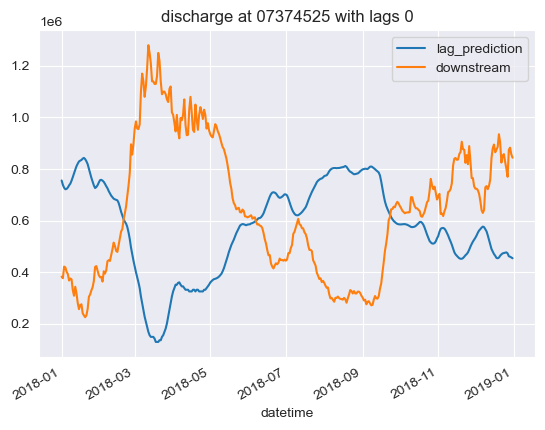

In [18]:
# Train SVM regression
N = len(filenames)
train_errors = []
valid_errors = []
extra_errors = []
test_errors = []
avg_rel_errors = []
# remember to read stations pairs beforehand
for i in range(N):
    # get data at one reach
    file = filenames[i] 
    data = pd.read_csv("./data/"+file, index_col="datetime")
    data.index =pd.to_datetime(data.index)

    # new columns of lag data
    lag_keys = []
    step = 1 if lags[i]>=0 else -1
    current_lag = 0
    for _ in range(abs(lags[i])+1):
        key = "lag_"+str(current_lag)
        lag_keys.append(key)
        data[key] = data["upstream"].shift(current_lag)
        current_lag = current_lag+step

    # get training data (3 years)
    firstday = pd.Timestamp("2015-01-01",tz=data.index[0].tz)
    lastday = pd.Timestamp("2017-12-31",tz=data.index[0].tz)
    train_df = data[firstday:lastday].copy()
    train_df.dropna(inplace=True)

    # Regression
    reg_lag = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    SVR(
        kernel="linear", 
        degree=3,
        gamma="auto",
        C=1,
        epsilon=10**(0),
        max_iter=50000
        ) 
    if train_df.size>50:
        X = train_df[lag_keys].values
        y = train_df["downstream"].values
        reg_lag.fit(X,y)
        
        # train errors
        y_train_lag = reg_lag.predict(X)
        train_errors.append( (mean_squared_error(y,y_train_lag))**0.5 )
    else:
        train_errors.append( None )

    # validation errors
    firstday = pd.Timestamp("2018-01-01",tz=data.index[0].tz)
    lastday = pd.Timestamp("2018-12-31",tz=data.index[0].tz)
    valid_df = data[firstday:lastday].copy()
    valid_df.dropna(inplace=True)

    if valid_df.size>50:
        X = valid_df[lag_keys].values
        y = valid_df["downstream"].values

        y_valid_lag = reg_lag.predict(X)
        valid_df["lag_prediction"] = y_valid_lag
        valid_df.plot(
            y=["lag_prediction","downstream"],
            use_index=True,
            title="discharge at "+stations[i]+" with lags "+str(lags[i])
            )
        plt.legend()

        valid_df["rel_err"] = (valid_df["lag_prediction"]-valid_df["downstream"])/valid_df["downstream"]
        avg_rel_errors.append( valid_df["rel_err"].mean() )
        valid_errors.append( (mean_squared_error(y,y_valid_lag))**0.5 )
    else:
        valid_errors.append( None )
        avg_rel_errors.append( None)
    break
